In [ ]:
#pip install python-binance pandas numpy matplotlib seaborn


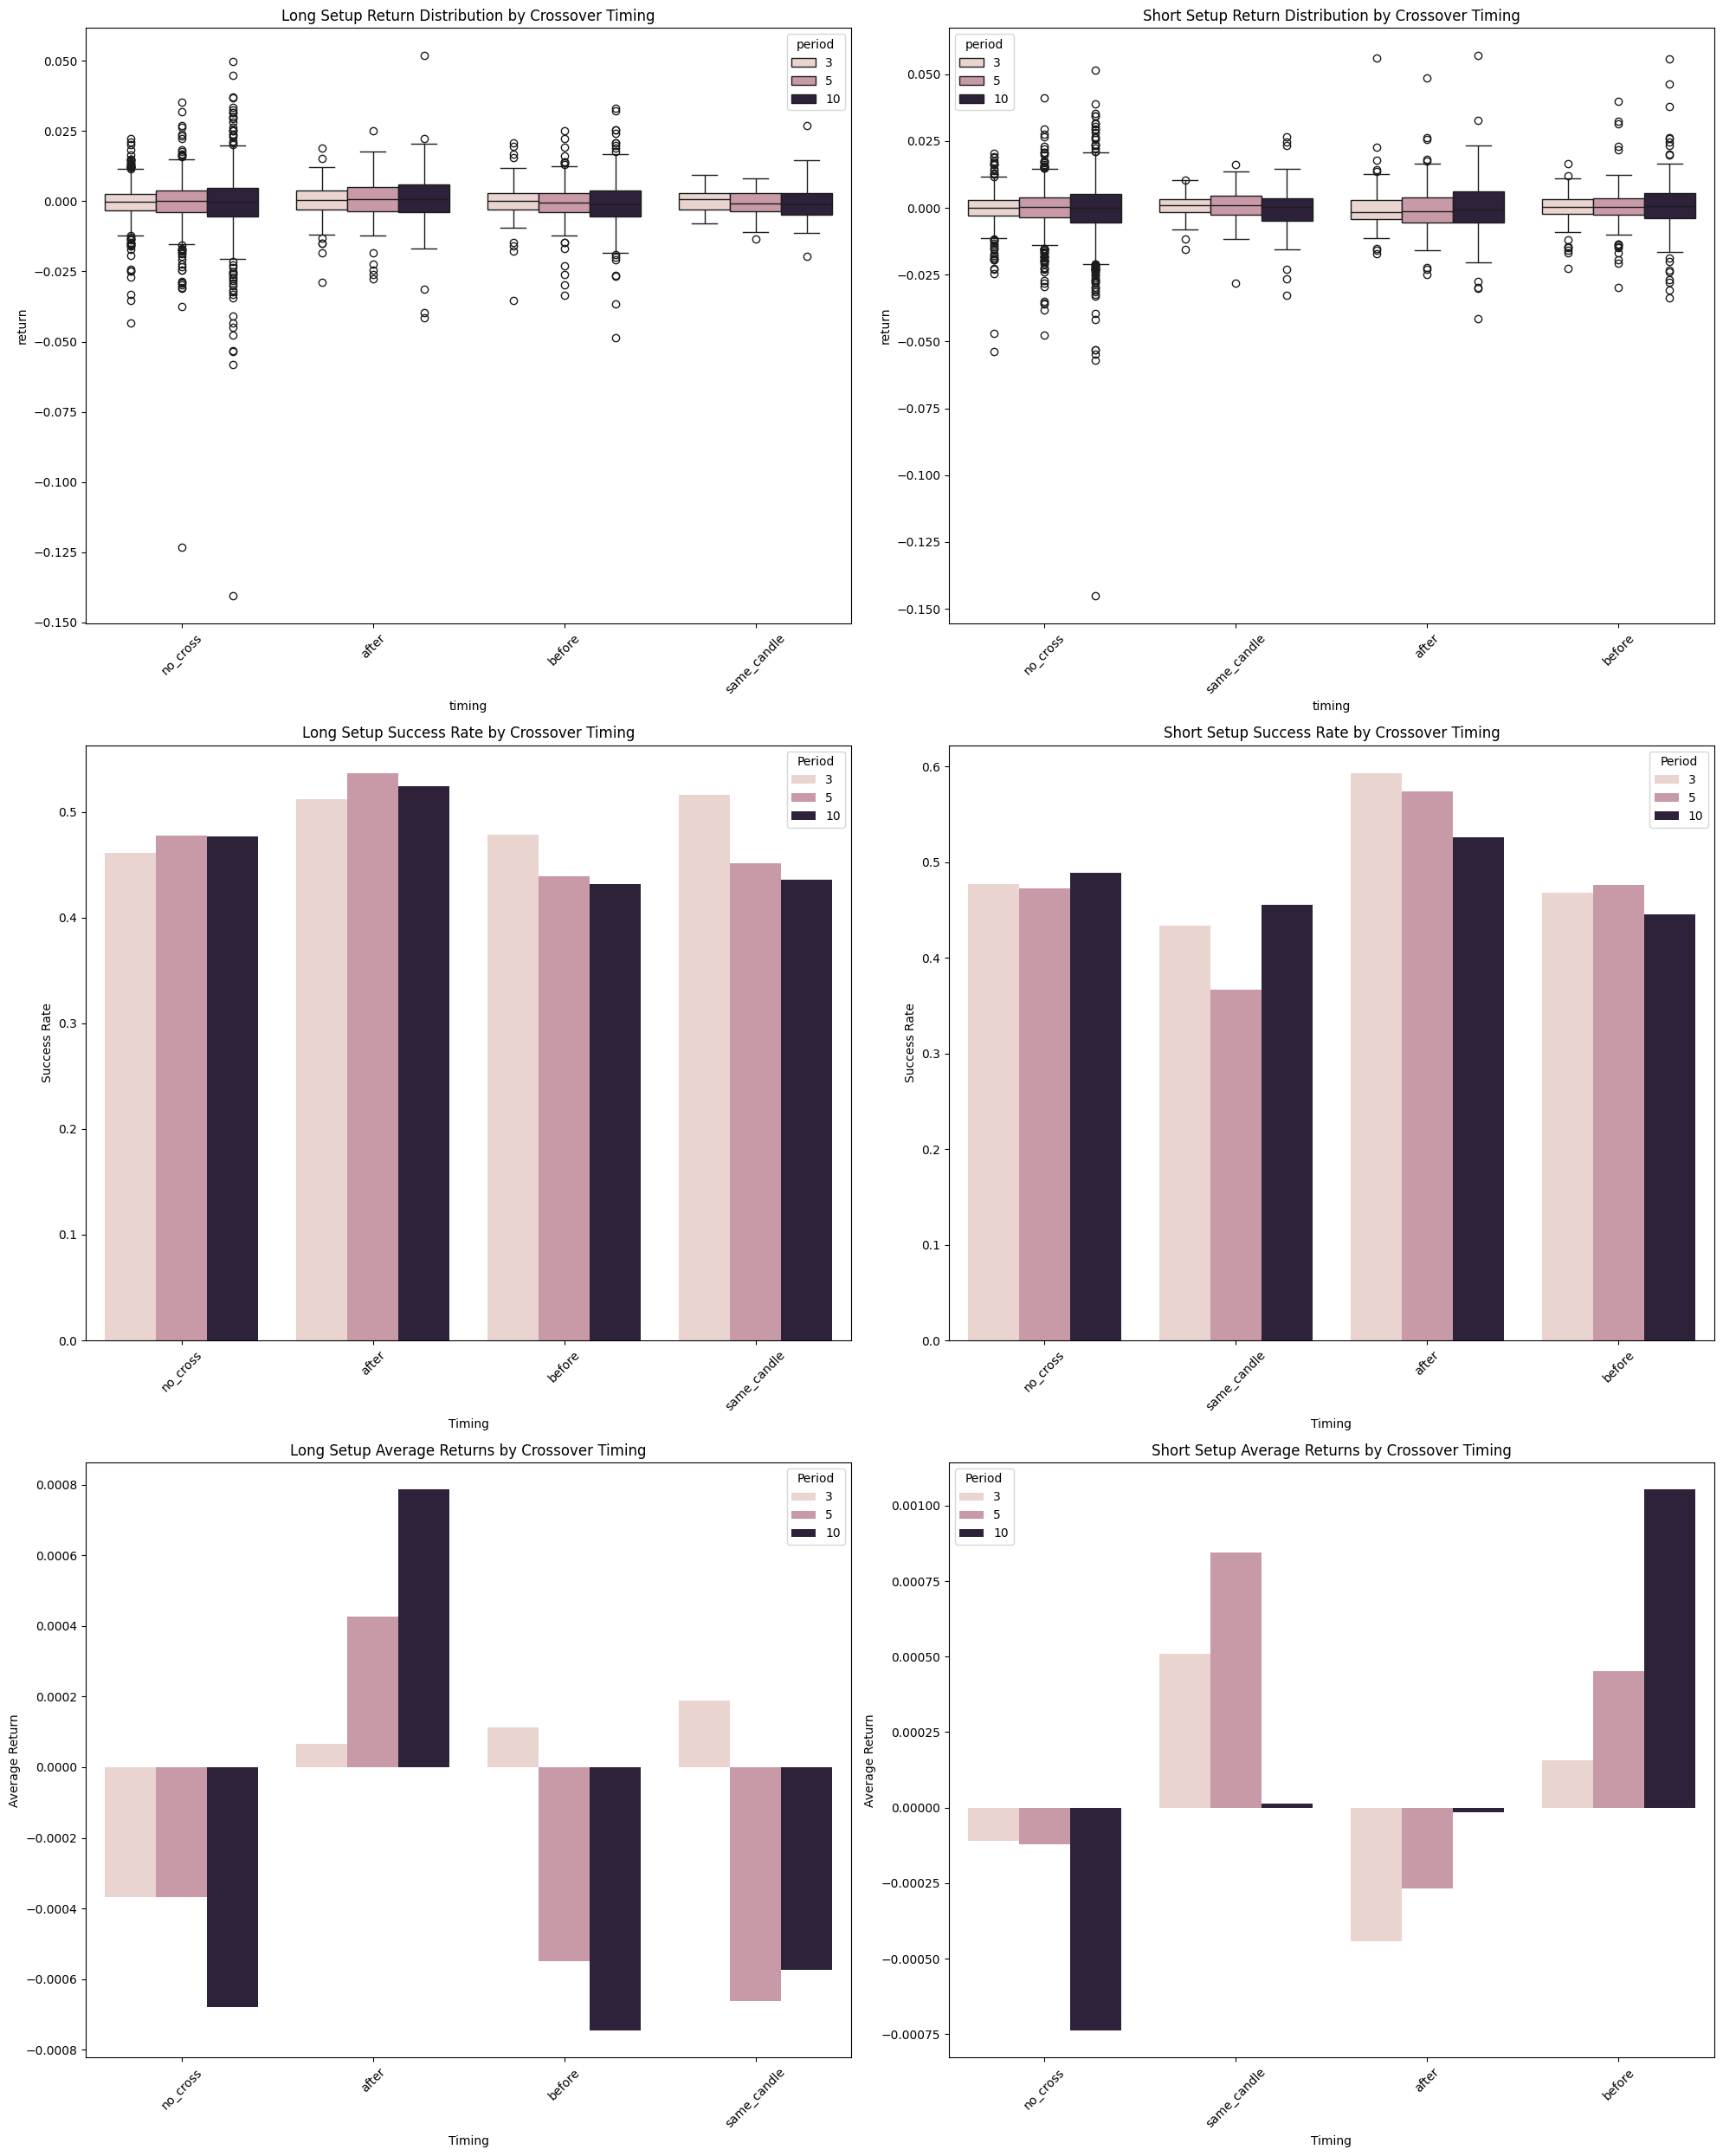

In [1]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class BinanceDataFetcher:
    def __init__(self, api_key='', api_secret=''):
        self.client = Client(api_key, api_secret)
        
    def get_historical_data(self, symbol, timeframe, start_date, end_date):
        """Fetch historical data from Binance"""
        klines = self.client.get_historical_klines(
            symbol,
            timeframe,
            start_date,
            end_date
        )
        
        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_volume', 'trades', 'taker_buy_base',
            'taker_buy_quote', 'ignored'
        ])
        
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        return df

class CryptoAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
    
    def calculate_indicators(self):
        """
        Calculates technical indicators and identifies trading signals,
        now separated into long and short setups
        """
        # EMA calculations
        self.df['ema8'] = self.df['close'].ewm(span=8, adjust=False).mean()
        self.df['ema20'] = self.df['close'].ewm(span=20, adjust=False).mean()
        
        # Gap calculations with direction
        self.df['bull_gap'] = (self.df['open'] > self.df['close'].shift()) & (self.df['close'] > self.df['open'])
        self.df['bear_gap'] = (self.df['open'] < self.df['close'].shift()) & (self.df['close'] < self.df['open'])
        self.df['gap_size'] = np.where(
            self.df['bull_gap'],
            self.df['open'] - self.df['close'].shift(),
            np.where(
                self.df['bear_gap'],
                self.df['close'].shift() - self.df['open'],
                0
            )
        )
        
        # EMA crossover with direction
        self.df['ema_cross'] = np.where(self.df['ema8'] > self.df['ema20'], 1, -1)
        self.df['ema_crossover'] = self.df['ema_cross'].diff() != 0
        self.df['is_bullish_cross'] = (self.df['ema_cross'] == 1) & self.df['ema_crossover']
        self.df['is_bearish_cross'] = (self.df['ema_cross'] == -1) & self.df['ema_crossover']
        
        # Analyze temporal relationships (excluding 'both')
        self.df['cross_timing'] = 'no_cross'
        lookback_window = 5
        lookforward_window = 5
        
        gap_indices = self.df[self.df['gap_size'] != 0].index
        for idx in gap_indices:
            start_idx = max(0, idx - lookback_window)
            end_idx = min(len(self.df) - 1, idx + lookforward_window)
            window_data = self.df.loc[start_idx:end_idx]
            
            if self.df.loc[idx, 'ema_crossover']:
                self.df.loc[idx, 'cross_timing'] = 'same_candle'
            else:
                prev_cross = window_data.loc[:idx]['ema_crossover'].any()
                next_cross = window_data.loc[idx:]['ema_crossover'].any()
                
                if prev_cross:
                    self.df.loc[idx, 'cross_timing'] = 'before'
                elif next_cross:
                    self.df.loc[idx, 'cross_timing'] = 'after'
        
        # Calculate returns for different periods
        for period in [3, 5, 10]:
            self.df[f'return_{period}'] = self.df['close'].pct_change(period).shift(-period)
        
        return self.df
    
    def analyze_signals(self, lookback_periods=[3, 5, 10]):
        plt.figure(figsize=(20, 25))  # Increased figure size for 6 plots
        
        # Separate long and short setups
        long_setups = self.df[self.df['bull_gap'] | self.df['is_bullish_cross']]
        short_setups = self.df[self.df['bear_gap'] | self.df['is_bearish_cross']]
        
        # Plot 1: Long Setup Return Distribution
        plt.subplot(3, 2, 1)
        timing_returns_long = []
        for period in lookback_periods:
            for timing in long_setups['cross_timing'].unique():
                returns = long_setups[long_setups['cross_timing'] == timing][f'return_{period}']
                timing_returns_long.extend([(ret, timing, period) for ret in returns])
        
        timing_df_long = pd.DataFrame(timing_returns_long, columns=['return', 'timing', 'period'])
        sns.boxplot(data=timing_df_long, x='timing', y='return', hue='period')
        plt.title('Long Setup Return Distribution by Crossover Timing')
        plt.xticks(rotation=45)
        
        # Plot 2: Short Setup Return Distribution
        plt.subplot(3, 2, 2)
        timing_returns_short = []
        for period in lookback_periods:
            for timing in short_setups['cross_timing'].unique():
                returns = short_setups[short_setups['cross_timing'] == timing][f'return_{period}']
                timing_returns_short.extend([(ret, timing, period) for ret in returns])
        
        timing_df_short = pd.DataFrame(timing_returns_short, columns=['return', 'timing', 'period'])
        sns.boxplot(data=timing_df_short, x='timing', y='return', hue='period')
        plt.title('Short Setup Return Distribution by Crossover Timing')
        plt.xticks(rotation=45)
        
        # Plot 3: Long Setup Success Rate
        plt.subplot(3, 2, 3)
        success_rates_long = []
        for period in lookback_periods:
            for timing in long_setups['cross_timing'].unique():
                mask = long_setups['cross_timing'] == timing
                success_rate = (long_setups[mask][f'return_{period}'] > 0).mean()
                success_rates_long.append((timing, period, success_rate))
        
        success_df_long = pd.DataFrame(success_rates_long, columns=['Timing', 'Period', 'Success Rate'])
        sns.barplot(data=success_df_long, x='Timing', y='Success Rate', hue='Period')
        plt.title('Long Setup Success Rate by Crossover Timing')
        plt.xticks(rotation=45)
        
        # Plot 4: Short Setup Success Rate
        plt.subplot(3, 2, 4)
        success_rates_short = []
        for period in lookback_periods:
            for timing in short_setups['cross_timing'].unique():
                mask = short_setups['cross_timing'] == timing
                success_rate = (short_setups[mask][f'return_{period}'] < 0).mean()  # Note: < 0 for shorts
                success_rates_short.append((timing, period, success_rate))
        
        success_df_short = pd.DataFrame(success_rates_short, columns=['Timing', 'Period', 'Success Rate'])
        sns.barplot(data=success_df_short, x='Timing', y='Success Rate', hue='Period')
        plt.title('Short Setup Success Rate by Crossover Timing')
        plt.xticks(rotation=45)
        
        # Plot 5: Long Setup Average Returns
        plt.subplot(3, 2, 5)
        avg_returns_long = []
        for period in lookback_periods:
            for timing in long_setups['cross_timing'].unique():
                mask = long_setups['cross_timing'] == timing
                avg_return = long_setups[mask][f'return_{period}'].mean()
                avg_returns_long.append((timing, period, avg_return))
        
        avg_df_long = pd.DataFrame(avg_returns_long, columns=['Timing', 'Period', 'Average Return'])
        sns.barplot(data=avg_df_long, x='Timing', y='Average Return', hue='Period')
        plt.title('Long Setup Average Returns by Crossover Timing')
        plt.xticks(rotation=45)
        
        # Plot 6: Short Setup Average Returns
        plt.subplot(3, 2, 6)
        avg_returns_short = []
        for period in lookback_periods:
            for timing in short_setups['cross_timing'].unique():
                mask = short_setups['cross_timing'] == timing
                avg_return = short_setups[mask][f'return_{period}'].mean()
                avg_returns_short.append((timing, period, avg_return))
        
        avg_df_short = pd.DataFrame(avg_returns_short, columns=['Timing', 'Period', 'Average Return'])
        sns.barplot(data=avg_df_short, x='Timing', y='Average Return', hue='Period')
        plt.title('Short Setup Average Returns by Crossover Timing')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    
    # Fetch data
    fetcher = BinanceDataFetcher()
    df = fetcher.get_historical_data(
        symbol='FILUSDT',
        timeframe='5m',
        start_date=start_date.strftime("%d %b %Y %H:%M:%S"),
        end_date=end_date.strftime("%d %b %Y %H:%M:%S")
    )
    
    # Analyze
    analyzer = CryptoAnalyzer(df)
    df_with_indicators = analyzer.calculate_indicators()
    
    # Show results
    analyzer.analyze_signals()

